### <font color='indigo'>1) Import the Required Packages and Load the Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#for hyperparameter optimization
#!pip install bayesian-optimization
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')

* The categorical variables in the dataset are already encoded.

In [3]:
df = pd.read_csv("CR2_Data_Processed.csv", header=0, skiprows=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    45528 non-null  float64
 1   no_of_children                         45528 non-null  float64
 2   net_yearly_income                      45528 non-null  float64
 3   no_of_days_employed                    45528 non-null  float64
 4   total_family_members                   45528 non-null  float64
 5   migrant_worker                         45528 non-null  float64
 6   yearly_debt_payments                   45528 non-null  float64
 7   credit_limit                           45528 non-null  float64
 8   credit_limit_used(%)                   45528 non-null  float64
 9   credit_score                           45528 non-null  float64
 10  prev_defaults                          45528 non-null  float64
 11  de

In [4]:
df.head()

,age,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,...,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Unknown,occupation_type_Waiters/barmen staff
0,46.0,0.0,107934.04,612.0,1.0,1.0,33070.28,18690.93,73.0,544.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.0,0.0,109862.62,2771.0,2.0,0.0,15329.53,37745.19,52.0,857.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,37.0,0.0,230153.17,204.0,2.0,0.0,48416.60,41598.36,43.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39.0,0.0,122325.82,11941.0,2.0,0.0,22574.36,32627.76,20.0,754.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46.0,0.0,387286.00,1459.0,1.0,0.0,38282.95,52950.64,75.0,927.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### <font color='indigo'>2) Data Preparation for the Model

#### Predictors-Target Split

In [5]:
X = df.drop(["credit_card_default"], axis=1) #predictors
Y = df[["credit_card_default"]] #target

#### Train-Val-Test Split

* Splitting the whole dataset into three sets: train, validation, and test with ratios of 80%, 10%, and 10% respectively.

In [6]:
train_size=0.8
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8, random_state=777)

test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=777)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(36422, 38)
(36422, 1)
(4553, 38)
(4553, 1)
(4553, 38)
(4553, 1)


(None, None)

#### Undersampling

In [7]:
X_Y_train = pd.concat([X_train.reset_index(drop = True),Y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_Y_train['credit_card_default'].value_counts()
nondefaults = X_Y_train[X_Y_train['credit_card_default'] == 0]
defaults = X_Y_train[X_Y_train['credit_card_default'] == 1]

nondefaults_under = nondefaults.sample(count_default)
X_Y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),defaults.reset_index(drop = True)], axis=0)

In [9]:
X_train = X_Y_train_under.drop(["credit_card_default"], axis=1) #predictors
Y_train = X_Y_train_under[["credit_card_default"]] #target

#### Feature Scaling

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.fit_transform(X_valid)
X_test = sc.transform(X_test)

### <font color='indigo'>3) Model Building

In [11]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 38))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, Y_train, batch_size = 10, epochs = 100,verbose = 0)

### <font color='indigo'>4) Model Performance Indicators

In [12]:
score, acc = classifier.evaluate(X_valid, Y_valid, batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

456/456 [==============================] - 1s 2ms/step - loss: 1.0832 - accuracy: 0.7595
Train score: 1.083239197731018
Train accuracy: 0.7594992518424988


In [13]:
Y_pred = classifier.predict(X_test)
Y_pred_cat = np.where(Y_pred > 0.5, 1, 0)
target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, Y_pred_cat, target_names=target_names))

143/143 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

 Non-Default       1.00      0.74      0.85      4190
     Default       0.25      1.00      0.40       363

    accuracy                           0.76      4553
   macro avg       0.63      0.87      0.63      4553
weighted avg       0.94      0.76      0.81      4553



Text(0.5, 23.52222222222222, 'Predicted label')

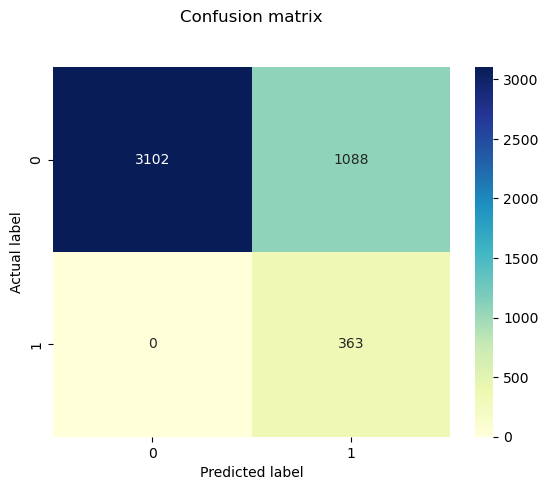

In [14]:
cm = confusion_matrix(Y_test, Y_pred_cat)
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

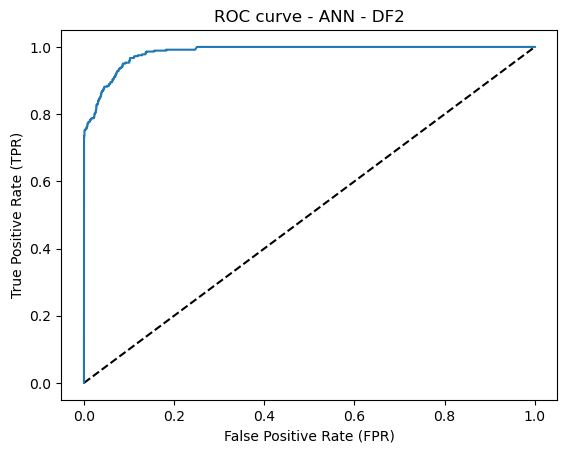

In [15]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - ANN - DF2')
plt.show()

In [16]:
#Area under ROC curve
roc_auc_score(Y_test, Y_pred)

0.984721592141857

### <font color='indigo'>5) Hyperparameter Tuning

In [20]:
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=38, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, Y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [21]:
params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
37/37 [==============================] - 0s 1ms/step
| 1         | 0.4998    | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.298     | 1.045     | 0.426     | 31.48     | 0.3377    | 6.935     |
37/37 [==============================] - 0s 1ms/step
| 2         | 0.5141    | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 1.932     | 1.237     | 0.08322   | 91.07     | 0.794     | 5.884     |
37/37 [==============================] - 0s 1ms/step
| 3         | 0.5       | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.055     | 1.908     | 0.1143    | 83.55     | 0.6977    | 3.957     |
37/37 [==============================] - 0s 1ms/ste

37/37 [==============================] - 0s 2ms/step
| 16        | 0.9301    | 1.051     | 209.3     | 0.9132    | 0.1537    | 87.45     | 1.19      | 2.607     | 0.07161   | 67.19     | 0.9688    | 2.782     |
37/37 [==============================] - 0s 1ms/step
| 17        | 0.5       | 5.936     | 371.9     | 0.8899    | 0.296     | 79.09     | 2.283     | 1.504     | 0.4811    | 34.13     | 0.8683    | 1.868     |
37/37 [==============================] - 0s 1ms/step
| 18        | 0.5716    | 8.757     | 370.8     | 0.2978    | 0.221     | 21.03     | 1.06      | 2.468     | 0.5033    | 29.63     | 0.00893   | 5.955     |
37/37 [==============================] - 0s 1ms/step
| 19        | 0.9543    | 4.828     | 778.8     | 0.6616    | 0.2516    | 51.06     | 1.852     | 2.656     | 0.4743    | 83.8      | 0.01418   | 2.777     |
37/37 [==============================] - 0s 2ms/step
| 20        | 0.5002    | 1.155     | 294.5     | 0.206     | 0.2243    | 94.41     | 1.761     | 1.921

In [22]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'relu',
 'batch_size': 405,
 'dropout': 0.6845756347569049,
 'dropout_rate': 0.10847525239268922,
 'epochs': 25,
 'layers1': 1,
 'layers2': 2,
 'learning_rate': 0.7813184853172991,
 'neurons': 45,
 'normalization': 0.029334209187537597,
 'optimizer': <keras.optimizers.optimizer_v2.adadelta.Adadelta at 0x2221cd0fe20>}

### <font color='indigo'>6) Final Model

In [25]:
# Fitting Neural Network
def nn_cl_fun():
    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=38, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
        nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
        nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
        nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn
        
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)
 
nn.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/25
15/15 [==============================] - 1s 13ms/step - loss: 0.6330 - accuracy: 0.6903 - val_loss: 0.6177 - val_accuracy: 0.6602
Epoch 2/25
15/15 [==============================] - 0s 5ms/step - loss: 0.3368 - accuracy: 0.8892 - val_loss: 0.7357 - val_accuracy: 0.6383
Epoch 3/25
15/15 [==============================] - 0s 5ms/step - loss: 0.1798 - accuracy: 0.9206 - val_loss: 1.0224 - val_accuracy: 0.5957
Epoch 4/25
15/15 [==============================] - 0s 5ms/step - loss: 0.1433 - accuracy: 0.9348 - val_loss: 1.3248 - val_accuracy: 0.5570
Epoch 5/25
15/15 [==============================] - 0s 4ms/step - loss: 0.1320 - accuracy: 0.9413 - val_loss: 1.2045 - val_accuracy: 0.6011
Epoch 6/25
15/15 [==============================] - 0s 5ms/step - loss: 0.1164 - accuracy: 0.9498 - val_loss: 1.2878 - val_accuracy: 0.6022
Epoch 7/25
15/15 [==============================] - 0s 4ms/step - loss: 0.1136 - accuracy: 0.9496 - val_loss: 1.2440 - val_accuracy: 0.6161
Epoch 8/25
15/15 [=

In [26]:
Y_pred_2 = nn.predict_proba(X_test)[:,1]
Y_pred_cat_2 = np.where(Y_pred_2 > 0.5, 1, 0)
target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, Y_pred_cat_2, target_names=target_names))

143/143 [==============================] - 0s 625us/step
              precision    recall  f1-score   support

 Non-Default       1.00      0.57      0.73      4190
     Default       0.17      1.00      0.29       363

    accuracy                           0.61      4553
   macro avg       0.58      0.79      0.51      4553
weighted avg       0.93      0.61      0.69      4553



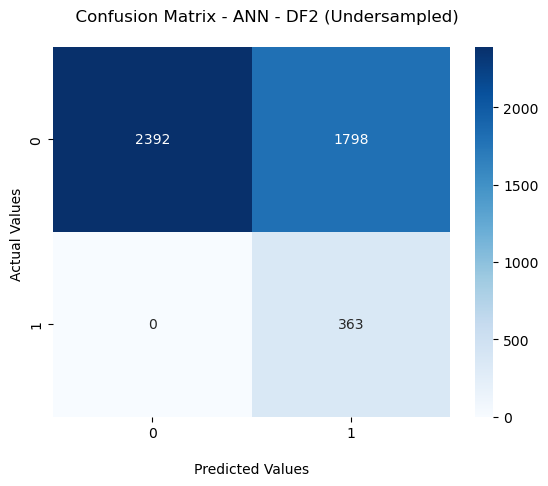

In [27]:
cm_final_model = confusion_matrix(Y_test, Y_pred_cat_2)
ax = sns.heatmap(cm_final_model, annot=True, annot_kws={"size": 10}, cmap='Blues', fmt="d")
ax.set_title('      Confusion Matrix - ANN - DF2 (Undersampled)\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

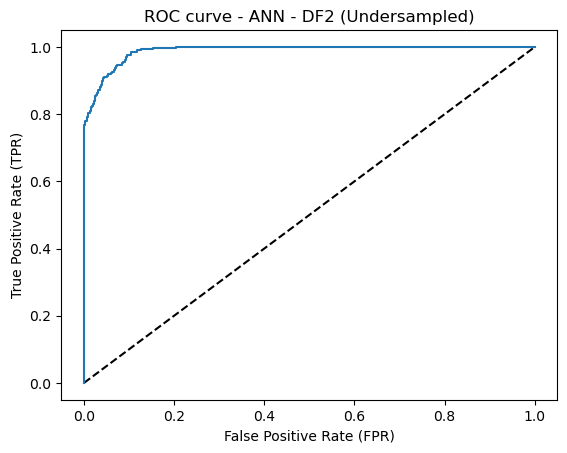

In [28]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve - ANN - DF2 (Undersampled)')
plt.show()

In [29]:
roc_auc_score(Y_test, Y_pred_2)

0.9886624982741277